In [3]:
import numpy as np
from sklearn.metrics import pairwise_distances
from gtda.homology import VietorisRipsPersistence
from torch.utils.data import DataLoader, TensorDataset  # type: ignore

from joblib import Parallel, delayed

class CurvatureSamplingGenerator(object):
    
    def __init__(self,
                 curvature_interval=(-2.0, 2.0),
                 num_samplings=100,
                 num_points_per_sampling=1_000,
                 homology_dimensions=(0, 1),
                 n_jobs=1,
    ):
        assert len(curvature_interval) == 2, "Curvature interval must be 2-dimensional"
        self._curvature_interval = curvature_interval
        self._num_samplings = num_samplings
        self._num_points_per_sampling = num_points_per_sampling
        self._homology_dimensions = homology_dimensions
        
        self._curvatures = np.random.uniform(low=curvature_interval[0],
                                             high=curvature_interval[1],
                                             size=(self._num_samplings))
        
        self._n_jobs = n_jobs
        
        self._compute_diagrams()
        
    
    def _phi(self, curvature, u_vect):
        if curvature > 0:
            r = (2/np.sqrt(curvature)) * np.arcsin(np.sqrt(u_vect) * np.sin(np.sqrt(curvature)/2))
        if curvature == 0:
            r = np.sqrt(u_vect)
        if curvature < 0:
            r = (2/np.sqrt(-curvature)) * np.arcsinh(np.sqrt(u_vect) * np.sinh(np.sqrt(-curvature)/2))
        return r    

    def _sample_uniformly(self, curvature, n_points):
        theta = 2 * np.pi * np.random.random_sample((n_points,))
        r = self._phi(curvature, np.random.random_sample((n_points,)))
        return np.stack((r,theta), axis = -1)
            
    def _geodesic_distance(self, curvature, x1 , x2):
        
        if curvature > 0:
            R = 1/np.sqrt(curvature)
            v1 = np.array([R * np.sin(x1[0]/R) * np.cos(x1[1]), 
                        R * np.sin(x1[0]/R) * np.sin(x1[1]),
                        R * np.cos(x1[0]/R)])
            
            v2 = np.array([R * np.sin(x2[0]/R) * np.cos(x2[1]), 
                        R * np.sin(x2[0]/R) * np.sin(x2[1]),
                        R * np.cos(x2[0]/R)])

            
            dist = R * np.arctan2(np.linalg.norm(np.cross(v1,v2)), (v1*v2).sum())
        
        elif curvature == 0:
            v1 = np.array([x1[0]*np.cos(x1[1]), x1[0]*np.sin(x1[1])])
            v2 = np.array([x2[0]*np.cos(x2[1]), x2[0]*np.sin(x2[1])])
            dist = np.linalg.norm( (v1 - v2) )  
        
        elif curvature < 0:
            R = 1/np.sqrt(-curvature)
            z = np.array([ np.tanh(x1[0]/(2 * R)) * np.cos(x1[1]),
                        np.tanh(x1[0]/(2 * R)) * np.sin(x1[1])])
            w = np.array([np.tanh(x2[0]/(2 * R)) * np.cos(x2[1]),
                        np.tanh(x2[0]/(2 * R)) * np.sin(x2[1])])
            temp = np.linalg.norm([(z*w).sum() - 1, np.linalg.det([z,w]) + 1])
            dist = 2 * R * np.arctanh(np.linalg.norm(z - w)/temp) 
            
        return dist

    def _compute_distance_matrix(self, curvature, n_points):
        metric = lambda x1, x2 : self._geodesic_distance(curvature, x1 , x2)
        samples = self._sample_uniformly(curvature, n_points)
        return pairwise_distances(samples, metric = metric)
    
    def _compute_diagrams(self):  
        """ This functions outputs the persistence diagrams in homological dimensions given by
        the homology dimensions, 
        for a list datasets obtained by uniformly sampling n_points for each elements in curvatures
        """
        
        distance_matrices = []
        VR = VietorisRipsPersistence(homology_dimensions=self._homology_dimensions,
                                     metric = 'precomputed',  n_jobs=self._n_jobs)
        # for curvature in self._curvatures:
        #     distance_matrix = self._compute_distance_matrix(curvature,
        #                                     self._num_points_per_sampling)
        #     distance_matrices.append(distance_matrix)
        
        def process(i):
            return self._compute_distance_matrix(self._curvatures[i],
                                            self._num_points_per_sampling)
        
        distance_matrices = Parallel(n_jobs=self._n_jobs)(delayed(process)(i)
                                                for i in range(len(self._curvatures)))
        
        self._diagrams = VR.fit_transform(distance_matrices)

    def _persistence_diagrams_to_one_hot(self, persistence_diagrams):
        """ Convert homology dimension to one-hot encoding

        Args:
            persistence_diagrams ([np.array]): persistence diagram with categorical
                homology dimension.

        Returns:
            [np.array]: persistent diagram with one-hot encoded homology dimension.
        """
        return np.concatenate(
            (
                self._diagrams[:, :, :2],  # point coordinates
                (np.eye(len(self._homology_dimensions))  # type: ignore
                [self._diagrams[:, :, -1].astype(np.int32)]),
            ),
            axis=-1)

    def get_diagrams(self):
        return self._persistence_diagrams_to_one_hot(self._diagrams)
    
    def get_curvatures(self):
        return self._curvatures
    
    def get_dataloader(self, **dataloaders_kwargs):
        DataLoader(TensorDataset(self._diagrams, self._curvatures),
                   **dataloaders_kwargs)

## Generate diagrams

In [4]:
from sklearn.svm import SVR as regression
from gtda.diagrams import PersistenceLandscape as PL
import numpy as np


# cg = CurvatureSamplingGenerator(num_samplings=200,
#                         num_points_per_sampling=300,
#                         n_jobs=-1)

curvatures = np.load('data/curvatures_5000_1000_0_1.npy')
diagrams = np.load('data/diagrams_5000_1000_0_1.npy')

# curvatures = cg.get_curvatures()
# diagrams = cg.get_diagrams()
#np.save('curvatures_10k.npy', curvatures)
#np.save('diagrams_curvature_10k.npy', diagrams)

# cg_test = CurvatureSamplingGenerator(num_samplings=200,
#                         num_points_per_sampling=300,
#                         n_jobs=-1)
# curvatures_test = cg_test.get_curvatures()
# diagrams_test = cg_test.get_diagrams()

curvatures_test = curvatures[-500:]
diagrams_test = diagrams[-500:]

curvatures = curvatures[:4500]
diagrams = diagrams[:4500]

## H^0 features

In [5]:
death_vector_sorted = np.sort(diagrams[:,:,1][diagrams[:,:,2] == 1.].reshape((diagrams.shape[0], -1)))
death_vector_sorted_test = np.sort(diagrams_test[:,:,1][diagrams_test[:,:,2] == 1.].reshape((diagrams_test.shape[0], -1)))

In [6]:
model1 = regression(kernel = 'linear', C = 100, epsilon = 0.)
model1.fit(death_vector_sorted, curvatures)

model2 = model = regression(kernel = 'rbf', C = 100, epsilon = 0.)
model2.fit(death_vector_sorted, curvatures)


SVR(C=100, epsilon=0.0)

In [7]:

model1.score(death_vector_sorted, curvatures), model1.score(death_vector_sorted_test, curvatures_test)

(0.6981198681505327, 0.7143661237999408)

In [8]:

model2.score(death_vector_sorted, curvatures), model2.score(death_vector_sorted_test, curvatures_test)

(0.9656722557365423, 0.9640487105614307)

## H^1 features

In [9]:
n_layers = 3
n_bins = 100

landscapes = PL(n_layers = n_layers, n_bins = n_bins)

In [10]:
diagrams_dim1 = diagrams[:,:,[0,1,3]][diagrams[:,:,3] == 1.].reshape((diagrams.shape[0], -1,3))

diagrams_dim1_test = diagrams_test[:,:,[0,1,3]][diagrams_test[:,:,3] == 1.].reshape((diagrams_test.shape[0], -1,3))

In [11]:
landscapes_data = landscapes.fit_transform(diagrams_dim1)
landscapes_data_test = landscapes.fit_transform(diagrams_dim1_test)

feature_dim1 = landscapes_data.reshape(diagrams.shape[0], n_layers*n_bins)

feature_dim1_test = landscapes_data_test.reshape(diagrams_test.shape[0], n_layers*n_bins)


In [12]:
model1 = regression(kernel = 'linear', C = 100, epsilon = 0.)
model1.fit(feature_dim1, curvatures)

model2 = model = regression(kernel = 'rbf', C = 100, epsilon = 0.)
model2.fit(feature_dim1, curvatures)

SVR(C=100, epsilon=0.0)

In [13]:
model1.score(feature_dim1, curvatures), model1.score(feature_dim1_test, curvatures_test)

(0.7822235253578014, 0.5102047911789964)

In [15]:
model2.score(feature_dim1, curvatures), model2.score(feature_dim1_test, curvatures_test)

(0.8713270747275474, -0.1759937952694841)

In [24]:
from sklearn.metrics import r2_score, mean_squared_error
mean_squared_error(model1.predict(feature_dim1_test), curvatures_test)

0.6510542410450116

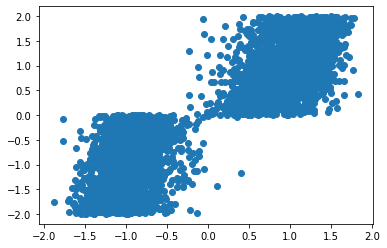

In [28]:
import matplotlib.pyplot as plt
plt.scatter(model1.predict(feature_dim1), curvatures)

## H^0 + H^1 features

In [29]:
model1 = regression(kernel = 'linear', C = 100, epsilon = 0.)
model1.fit(feature_dim1, curvatures)

model2 = model = regression(kernel = 'rbf', C = 100, epsilon = 0.)
model2.fit(feature_dim1, curvatures)

SVR(C=100, epsilon=0.0)

In [30]:
features_total = np.concatenate((death_vector_sorted,feature_dim1), axis = 1)

features_total_test = np.concatenate((death_vector_sorted_test,feature_dim1_test), axis = 1)

In [31]:
model1 = regression(kernel = 'linear', C = 100, epsilon = 0.)
model1.fit(features_total, curvatures)

model2 = model = regression(kernel = 'rbf', C = 100, epsilon = 0.)
model2.fit(features_total, curvatures)



SVR(C=100, epsilon=0.0)

In [32]:
model1.score(features_total, curvatures), model1.score(features_total_test, curvatures_test)

(0.7849379372537524, 0.4809939322569119)

In [33]:
model2.score(features_total, curvatures), model2.score(features_total_test, curvatures_test)

(0.9734322030714032, 0.8932139266985516)

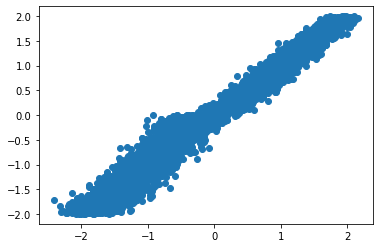

In [35]:
import matplotlib.pyplot as plt
plt.scatter(model2.predict(features_total), curvatures)

In [36]:
mean_squared_error(model2.predict(features_total), curvatures)

0.03516929013262908

(-2.6414958155949755,
 2.3914693663842517,
 -2.1997343771824105,
 2.199786869017784)

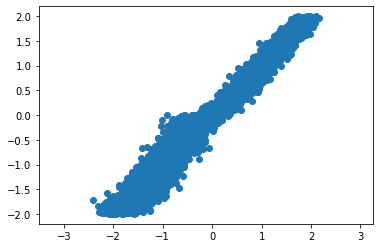

In [37]:
import matplotlib.pyplot as plt
plt.scatter(model2.predict(features_total), curvatures)
plt.axis('equal')
